##  Data Description: The dataset holds customer information that aims at predicting whether a prospective customer responds to a marketing campaign or not. 

The dataset contains a total of 22 variables, the class outcome/response being stored in the column "responded" and the rest of the predictors. The dataset is a combination of both numeric and categorical variables with a few variables containing a lot of missing values.

The problem was tackled in the following sequence:

1. Import the dataset and shape it to identify the missing values by replacing blank spaces with NA values

2. Conduct Exploratory Data Analysis to  find out the distributions (nature) of variables containing the missing values and identify whether some correlations exist between the predictor variables

3. Conduct a variable importance analysis, based on measures like the Mean Decrease in GINI to identify the variables containing the most amount of information to conduct classification

4. Using exploratory analysis and descriptive statistics to identify a suitable missing value imputation technique, or whether to carry out missing value imputation at all.

5. Once missing value problem was tackled, class balancing was achieved with a suitable scheme.

6. With both missing values tackled and classes balanced, different classsification models/schemes were built to check the performance of the model. Generalisation error rate, Balanced error rate, Sensitivity and Specificity are some of the accuracy measures which were checked. Validation on the training set was done using 10-fold cross validation and a part of the training set was kept to make predictions on unseen data records.

7. The test set was imputed with missing values with the same scheme that was used for the training set.

8. The final classification model was used to generate predictions for the imputed test set, which were recorded in the CSV file attached.



# 1. Exploratory Analysis

In [2]:
    #Loading the package management tool to install & load packages
pacman::p_load(Hmisc, ROCR,gmodels,Amelia, mice,lattice, xgboost, readr, stringr, vegan,psych,FactoMineR, PCAmixdata, RWeka, DMwR, rattle, car,caret, MASS, e1071, mlbench, klaR, combinat,ggplot2, googleVis,randomForest, reshape2, VIM)

In [3]:
#importing the dataset into a dataframe
train <- read.csv('......../marketing_training.csv', na.strings='')

In [4]:
#Structure of dataset
str(train)

'data.frame':	7414 obs. of  22 variables:
 $ custAge       : int  55 NA 42 55 NA 47 35 NA 28 46 ...
 $ profession    : Factor w/ 12 levels "admin.","blue-collar",..: 1 2 10 5 1 2 8 8 11 2 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 3 2 2 1 1 2 3 2 2 2 ...
 $ schooling     : Factor w/ 8 levels "basic.4y","basic.6y",..: 7 NA 4 NA 7 1 NA 4 3 3 ...
 $ default       : Factor w/ 3 levels "no","unknown",..: 2 1 1 2 1 1 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 1 1 3 3 3 3 3 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 3 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 1 1 2 1 1 2 2 2 1 1 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 8 4 7 4 7 7 7 7 7 8 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 2 2 5 4 1 4 5 1 2 ...
 $ campaign      : int  1 1 1 2 5 1 1 2 1 2 ...
 $ pdays         : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous     

In [5]:
#Contents function describes the levels in the categorical variables and the missing values in each variable.
contents(train)


Data frame:train	7414 observations and 22 variables    Maximum # NAs:2155


               Levels Storage  NAs
custAge               integer 1804
profession         12 integer    0
marital             4 integer    0
schooling           8 integer 2155
default             3 integer    0
housing             3 integer    0
loan                3 integer    0
contact             2 integer    0
month              10 integer    0
day_of_week         5 integer  711
campaign              integer    0
pdays                 integer    0
previous              integer    0
poutcome            3 integer    0
emp.var.rate           double    0
cons.price.idx         double    0
cons.conf.idx          double    0
euribor3m              double    0
nr.employed            double    0
pmonths                double    0
pastEmail             integer    0
responded           2 integer    0

+-----------+------------------------------------------------------------+
|Variable   |Levels                       

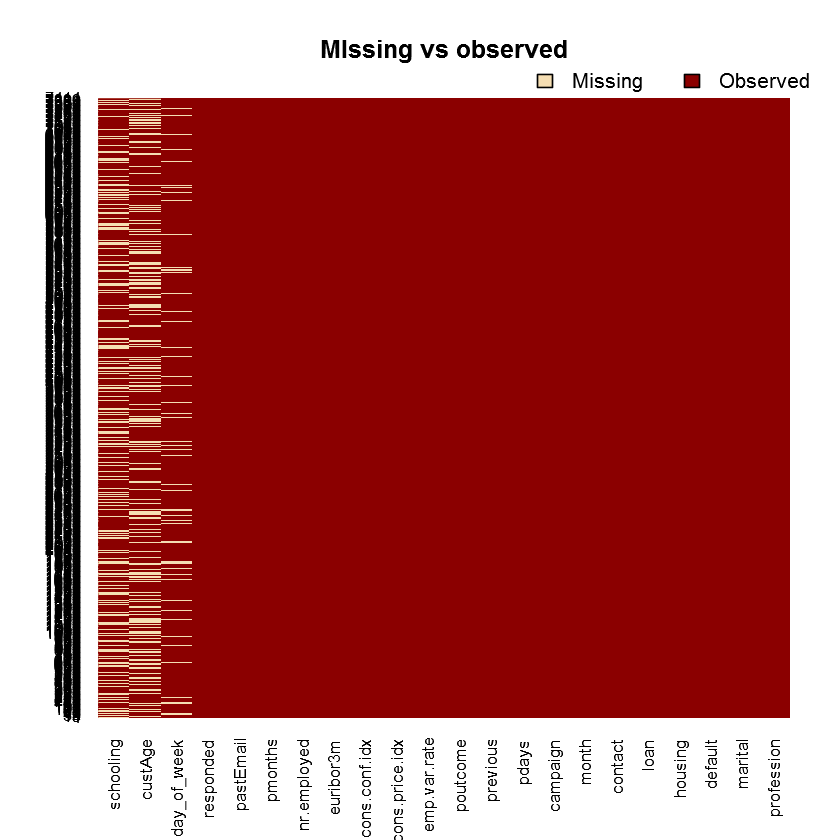

In [6]:
#Visualizing the features with missing values
missmap(train,main="MIssing vs observed")

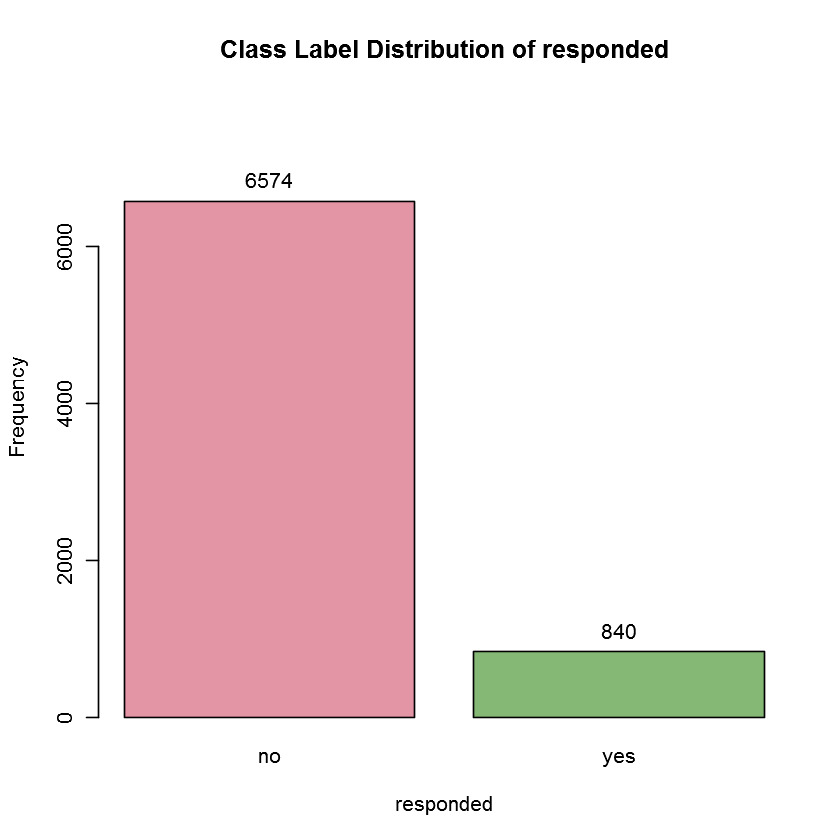

In [7]:
# Generate the summary data for plotting.
ds <- rbind(summary(na.omit(train[,]$responded)))

# Sort the entries.
ord <- order(ds[1,], decreasing=TRUE)

# Plot the data.
bp <-  barplot2(ds[,ord], beside=TRUE, ylab="Frequency", xlab="responded", ylim=c(0, 7889), col=colorspace::rainbow_hcl(3))

# Add the actual frequencies.
text(bp, ds[,ord]+263, ds[,ord])

# Add a title to the plot.
title(main="Class Label Distribution of responded")


The class imbalance is pretty significant, with 6574 instances belonging to the "no" class and 840 instances belonging to the "yes" class. 
If the model is built on imbalanced data, then prediction accuracy will be biased as the model gets trained in an unbalanced fashion. 

In [9]:
#Looking at a subset of the data
head(train)

custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
55,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999,0,no
NA,blue-collar,married,NA,no,no,no,cellular,jul,mon,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999,0,no
42,technician,married,high.school,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999,0,no
55,management,divorced,NA,unknown,yes,yes,cellular,jul,wed,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999,0,no
NA,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,...,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999,1,no
47,blue-collar,married,basic.4y,no,yes,no,telephone,may,fri,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999,0,no


# 2. Data Transformations

Missing Value imputation is an important step to data cleaning. The three variables custAge, Schooling and Day_of week have missing values. One option was to remove the missing values and build the model, doing which results in loss of information. Given that the test set also has a lot of missing values, it doesnt make sense to build a model by removing missing value instances. 

Instead, an appropriate imputation technique was used to impute the missing values.

## The MICE Package

Several simpler imputation techniques like mean, median, K-Means etc were considered and rejected due to the following concerns
Mean imputation works well only if we assume the underlying distrubtion of the variable to be imputed is normal. Also, it only works for numerical data. Median imputation doesn't work for categorical data

K-means imputation works on euclidean distances, which might not be the right approach to run of categorical data as the distances dont signify anything in categorical data
The MICE package provides us with the most robust imputation techniques. MICE assumes that the missing data are Missing at Random (MAR), which means that the probability that a value is missing depends only on observed value and can be predicted using them. It imputes data on a variable by variable basis by specifying an imputation model per variable.

Since we have mixed data types,(1 numeric and 2 categorical) we need different imputation schemes to impute data which MICE provides.

MICE works by regressing each variable onto the other and then filling the missing values by using the fitted regression model. Predictive Mean matching (PMM) is a good technique which is used by defualt and works well on categorical variables as they are auto encoded.

m=5 represents that we created 5 different datasets with different imputed values, and we can select one on random or choose a combination of all 5. Combination of all 5 results in high computation time, so only 1 was used.

Advantages of MICE
1. As variables are regressed onto each other, imputed missing values use the information present in other variables. 
2. Works well both for numeric and categorical data as regression/logistic regression method gives a good fit, especially since so many variables have high correlations with each other.
3. Has a statistical significance to imputing values in such a fashion

Cons
1. Since the values imputed have a random bias to it, more datasets of imputed data need to be considered, which takes a lot of time

In [10]:
#Copying the original training dataset to another dataframe
training = train


 Variables sorted by number of missings: 
       Variable      Count
      schooling 0.29066631
        custAge 0.24332344
    day_of_week 0.09589965
     profession 0.00000000
        marital 0.00000000
        default 0.00000000
        housing 0.00000000
           loan 0.00000000
        contact 0.00000000
          month 0.00000000
       campaign 0.00000000
          pdays 0.00000000
       previous 0.00000000
       poutcome 0.00000000
   emp.var.rate 0.00000000
 cons.price.idx 0.00000000
  cons.conf.idx 0.00000000
      euribor3m 0.00000000
    nr.employed 0.00000000
        pmonths 0.00000000
      pastEmail 0.00000000
      responded 0.00000000


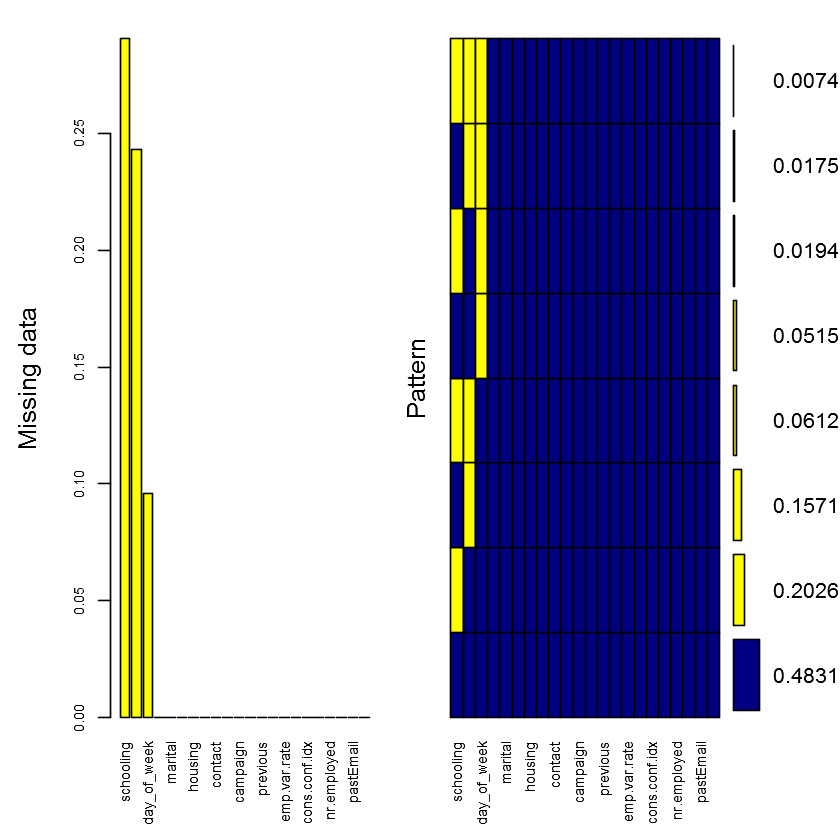

In [11]:
#visualizing missing data using the 'VIM' package
mice_plot <- aggr(training, col=c("navyblue","yellow"),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(numeric), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))



In [12]:
#Imputing missing values using the MICE package
imputed_Data_training <- mice(training, m=5, maxit = 50, seed = 500)
#Adding the imputed data records to the dataset
completedDatatrain <- complete(imputed_Data_training,1)


 iter imp variable
  1   1  custAge  schooling  day_of_week
  1   2  custAge  schooling  day_of_week
  1   3  custAge  schooling  day_of_week
  1   4  custAge  schooling  day_of_week
  1   5  custAge  schooling  day_of_week
  2   1  custAge  schooling  day_of_week
  2   2  custAge  schooling  day_of_week
  2   3  custAge  schooling  day_of_week
  2   4  custAge  schooling  day_of_week
  2   5  custAge  schooling  day_of_week
  3   1  custAge  schooling  day_of_week
  3   2  custAge  schooling  day_of_week
  3   3  custAge  schooling  day_of_week
  3   4  custAge  schooling  day_of_week
  3   5  custAge  schooling  day_of_week
  4   1  custAge  schooling  day_of_week
  4   2  custAge  schooling  day_of_week
  4   3  custAge  schooling  day_of_week
  4   4  custAge  schooling  day_of_week
  4   5  custAge  schooling  day_of_week
  5   1  custAge  schooling  day_of_week
  5   2  custAge  schooling  day_of_week
  5   3  custAge  schooling  day_of_week
  5   4  custAge  schooling  day_of_w

In [13]:
head(completedDatatrain)

custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
55,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999,0,no
41,blue-collar,married,high.school,no,no,no,cellular,jul,mon,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999,0,no
42,technician,married,high.school,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999,0,no
55,management,divorced,university.degree,unknown,yes,yes,cellular,jul,wed,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999,0,no
58,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,...,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999,1,no
47,blue-collar,married,basic.4y,no,yes,no,telephone,may,fri,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999,0,no


In [14]:
#Verifying if the dataset still has missing values
sum(is.na(completedDatatrain))

[1] 0

The MICE function has successfully imputed all the missing values

## SMOTE - Eliminating Class Imbalance

To solve the class imbalance, we can do the following: under-sampling or over-sampling. The dataset being small, we can go ahead with over-sampling as we don’t have a lot of data instances. Under-sampling the majority class may be helpful, but might result in a loss of information. The other choice is to oversample the minority class with replacement or create synthetic examples.

Looking at literature and studying the underlying dataset, a combination of the SMOTE (Synthetic Minority Oversampling Technique) minority class over-sampling and the majority class under-sampling using the subsample filter is incorporated, to obtain a balanced dataset with equal representation of both classes. SMOTE is considered a better fit as synthetically created instances for minority class seem to avoid the overfitting of data which could be encountered if repeated sampling of minority class instances is performed. In SMOTE, Synthetic samples are generated by operating in a feature space rather than data space. SMOTE seems to handle class imbalance problems well and methods like trees generalize well when instances are created by SMOTE. 

In [15]:
#Running SMOTE on the Dataset
balanced <- SMOTE(responded ~ ., completedDatatrain, perc.over = 300, perc.under=150)

In [16]:
#Checking the class distribution after generating synthetic samples
prop.table(table(balanced$responded))


       no       yes 
0.5294118 0.4705882 

There are multiple ways to evaluate the performance of a classifier. In this problem, we use the Holdout & Cross-Validation methods. 

1) Holdout Method: The original data with labeled examples is oartitioned into two disjoint sets, called training(trainpart) & test(testpart) sets, respectively. The proportion of data reserved for training & testing is 80-20.

2) Cross-Validation: k-fold cross validation is used in some of the following classifiers, where the data is segmented into k equal sized partitions. During each run, one of the partitions is chosen for testing while the rest of them are used for training. The leave-one-out approach has the test set containing only one record. This approach utilizes as much data as possible for training.  

In [17]:
set.seed(123)
validation_index <- createDataPartition(balanced$responded, p=0.80, list=FALSE)
# select 20% of the data for validation
testpart <- balanced[-validation_index[sample(1:nrow(validation_index))],]
# use the remaining 80% of data to training and testing the models
trainpart <- balanced[validation_index[sample(1:nrow(validation_index))],]


# 3. Model Building

As the dataset contains a mix of both categorical and numerical data, the inherent structure of the dataset makes it appropriate to use a tree based method to classify instances. Trees produce good classifiers on mixed datatypes and also when class balancing has been done using SMOTE. 

Different machine learning schemes were used- J48, AdaboostM1( boosted trees), Bagging with J48, RandomForests and XGboost. 
Basic tuning was done on all schemes initially to benchmark the perfomance. The best performing model was then picked, to further tune it. 

Balanced Error Rate is chosen as the performance metric as opposed to Accuracy because, it gives a good estimate of whether the model is biased towards one class or performs equally well on classifying test instances across both the classes. Accuracy on the other hand could be quite misleading. We could have a really high accuracy but, it might turn out that most of the correctly classified instances belong to one class.

XGboost performed the best with the least Balanced Error Rate of around 0.09. 
XGboost is used for predictions on the test set.

In [18]:
#explains the tuning parameters used in the Rweka package
WOW(J48)

-U      Use unpruned tree.
-O      Do not collapse tree.
-C <pruning confidence>
        Set confidence threshold for pruning.  (default 0.25)
	Number of arguments: 1.
-M <minimum number of instances>
        Set minimum number of instances per leaf.  (default 2)
	Number of arguments: 1.
-R      Use reduced error pruning.
-N <number of folds>
        Set number of folds for reduced error pruning. One fold is used
        as pruning set.  (default 3)
	Number of arguments: 1.
-B      Use binary splits only.
-S      Do not perform subtree raising.
-L      Do not clean up after the tree has been built.
-A      Laplace smoothing for predicted probabilities.
-J      Do not use MDL correction for info gain on numeric attributes.
-Q <seed>
        Seed for random data shuffling (default 1).
	Number of arguments: 1.
-doNotMakeSplitPointActualValue
        Do not make split point actual value.
-output-debug-info
        If set, classifier is run in debug mode and may output
        additional in

## Decision Tree

In [19]:
j48model <- J48(responded ~ ., data= trainpart, control= Weka_control(M=1, C=0.05, B= TRUE))
evaluate_Weka_classifier(j48model, numFolds = 10)

=== 10 Fold Cross Validation ===

=== Summary ===

Correctly Classified Instances        5127               89.7584 %
Incorrectly Classified Instances       585               10.2416 %
Kappa statistic                          0.7936
Mean absolute error                      0.1628
Root mean squared error                  0.2966
Relative absolute error                 32.6776 %
Root relative squared error             59.425  %
Total Number of Instances             5712     

=== Confusion Matrix ===

    a    b   <-- classified as
 2829  195 |    a = no
  390 2298 |    b = yes

## Bagging

In [20]:
baggingmodel <- Bagging(responded ~ ., data= trainpart, control= Weka_control(W= list(J48, M=1, R=TRUE, N=3)))
evaluate_Weka_classifier(baggingmodel, numFolds = 10, class= TRUE)

=== 10 Fold Cross Validation ===

=== Summary ===

Correctly Classified Instances        5159               90.3186 %
Incorrectly Classified Instances       553                9.6814 %
Kappa statistic                          0.8048
Mean absolute error                      0.1553
Root mean squared error                  0.2804
Relative absolute error                 31.1593 %
Root relative squared error             56.1698 %
Total Number of Instances             5712     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.943    0.142    0.882      0.943    0.912      0.807    0.943     0.920     no
                 0.858    0.057    0.931      0.858    0.893      0.807    0.943     0.953     yes
Weighted Avg.    0.903    0.102    0.905      0.903    0.903      0.807    0.943     0.936     

=== Confusion Matrix ===

    a    b   <-- classified as
 2853  171 |    a = no
  382 2306 

## AdaBoost

In [21]:
adaboostmodel <- AdaBoostM1(responded ~ ., data= trainpart, control= Weka_control(W= list(J48, M=1, C=0.05, B= TRUE )))
evaluate_Weka_classifier(adaboostmodel, numFolds = 10, confusionMatrix= TRUE, class= TRUE)

=== 10 Fold Cross Validation ===

=== Summary ===

Correctly Classified Instances        5065               88.673  %
Incorrectly Classified Instances       647               11.327  %
Kappa statistic                          0.772 
Mean absolute error                      0.1111
Root mean squared error                  0.3167
Relative absolute error                 22.2919 %
Root relative squared error             63.443  %
Total Number of Instances             5712     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.916    0.146    0.876      0.916    0.895      0.773    0.934     0.912     no
                 0.854    0.084    0.900      0.854    0.877      0.773    0.934     0.941     yes
Weighted Avg.    0.887    0.117    0.887      0.887    0.887      0.773    0.934     0.926     

=== Confusion Matrix ===

    a    b   <-- classified as
 2769  255 |    a = no
  392 2296 

## XGBoost

XGboost is a special modification of Gradient Boosted trees with a provision to add regularization parameters which avoid large value coefficients and controlling overfitting. It takes the best features of boosting ( ie. producing good results from weak learners) and uses an optimization model at its core with shrinkage parameters. The gradient descent algorithm at its core leads to better performance and less overfitting. 

For the given data, XGboost performs the best.

With the above models evaluated, XGboost offer us a good amount of robustness, good flexibility and seems to perform consistently with less difference in accuracy over a range of parameter values. Its chosen to generate the classifications on the test set. 
It's expected to perform better than other learning methods in accuracy as well as balanced error rates and specificity. 


In [25]:
#Extracting the feature names from feature space
feature.names <- names(trainpart)[1:ncol(trainpart)-1]

In [26]:
feature.names

[1] "custAge"        "profession"     "marital"        "schooling"     
 [5] "default"        "housing"        "loan"           "contact"       
 [9] "month"          "day_of_week"    "campaign"       "pdays"         
[13] "previous"       "poutcome"       "emp.var.rate"   "cons.price.idx"
[17] "cons.conf.idx"  "euribor3m"      "nr.employed"    "pmonths"       
[21] "pastEmail"

In [27]:
#XGBoost only functions with numeric variables. This calls for converting all the categorical factors into numeric data
cat("assuming text variables are categorical & replacing them with numeric ids\n")
for (f in feature.names) {
  if (class(trainpart[[f]])=="character") {
    levels <- unique(c(trainpart[[f]], testpart[[f]]))
    trainpart[[f]] <- as.integer(factor(trainpart[[f]], levels=levels))
    testpart[[f]]  <- as.integer(factor(testpart[[f]],  levels=levels))
  }
}

assuming text variables are categorical & replacing them with numeric ids


In [28]:
#The response variable has to be converted to binary (0,1) in order to support a Logistic Regression learner
trainpart$responded = as.numeric(trainpart$responded) 
trainpart$responded = ifelse(trainpart$responded == 2,0,1)  

In [58]:
cat("training an XGBoost classifier\n")
xgtrain <- xgboost(data        = data.matrix(trainpart[,feature.names]),
               label       = trainpart$responded,
               nrounds     = 100,
               gamma       = 2, 
               max_depth   = 12, 
               lambda   = 2,
               objective   = "binary:logistic",
               eval_metric = "error")

training an XGBoost classifier
[1]	train-error:0.077556 
[2]	train-error:0.075980 
[3]	train-error:0.069503 
[4]	train-error:0.069328 
[5]	train-error:0.066527 
[6]	train-error:0.064076 
[7]	train-error:0.062325 
[8]	train-error:0.061625 
[9]	train-error:0.060924 
[10]	train-error:0.061800 
[11]	train-error:0.060049 
[12]	train-error:0.059349 
[13]	train-error:0.058824 
[14]	train-error:0.056898 
[15]	train-error:0.057073 
[16]	train-error:0.055147 
[17]	train-error:0.053221 
[18]	train-error:0.053396 
[19]	train-error:0.051646 
[20]	train-error:0.050070 
[21]	train-error:0.047969 
[22]	train-error:0.049020 
[23]	train-error:0.047794 
[24]	train-error:0.047094 
[25]	train-error:0.047619 
[26]	train-error:0.047444 
[27]	train-error:0.046744 
[28]	train-error:0.044818 
[29]	train-error:0.045343 
[30]	train-error:0.044818 
[31]	train-error:0.043943 
[32]	train-error:0.043067 
[33]	train-error:0.042542 
[34]	train-error:0.042192 
[35]	train-error:0.041842 
[36]	train-error:0.041842 
[37]	t

In [59]:
submission <- data.frame(Actual=testpart$responded)
for (rows in split(1:nrow(testpart),ceiling((1:nrow(testpart))/10000))) {
    submission[rows, "output"] <- predict(xgtrain, data.matrix(testpart[rows,feature.names]))
}

In [60]:
submission$Predicted = as.factor(ifelse(submission$output>0.5,'no','yes'))

In [61]:
str(submission)

'data.frame':	1428 obs. of  3 variables:
 $ Actual   : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ output   : num  0.947 0.933 0.978 0.876 0.973 ...
 $ Predicted: Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...


In [63]:
confusionMatrix(submission$Actual, submission$Predicted)

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  717  39
       yes  93 579
                                          
               Accuracy : 0.9076          
                 95% CI : (0.8913, 0.9221)
    No Information Rate : 0.5672          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8137          
 Mcnemar's Test P-Value : 3.968e-06       
                                          
            Sensitivity : 0.8852          
            Specificity : 0.9369          
         Pos Pred Value : 0.9484          
         Neg Pred Value : 0.8616          
             Prevalence : 0.5672          
         Detection Rate : 0.5021          
   Detection Prevalence : 0.5294          
      Balanced Accuracy : 0.9110          
                                          
       'Positive' Class : no              
                                          

In [64]:
mat <- xgb.importance (feature_names = feature.names,model = xgtrain)

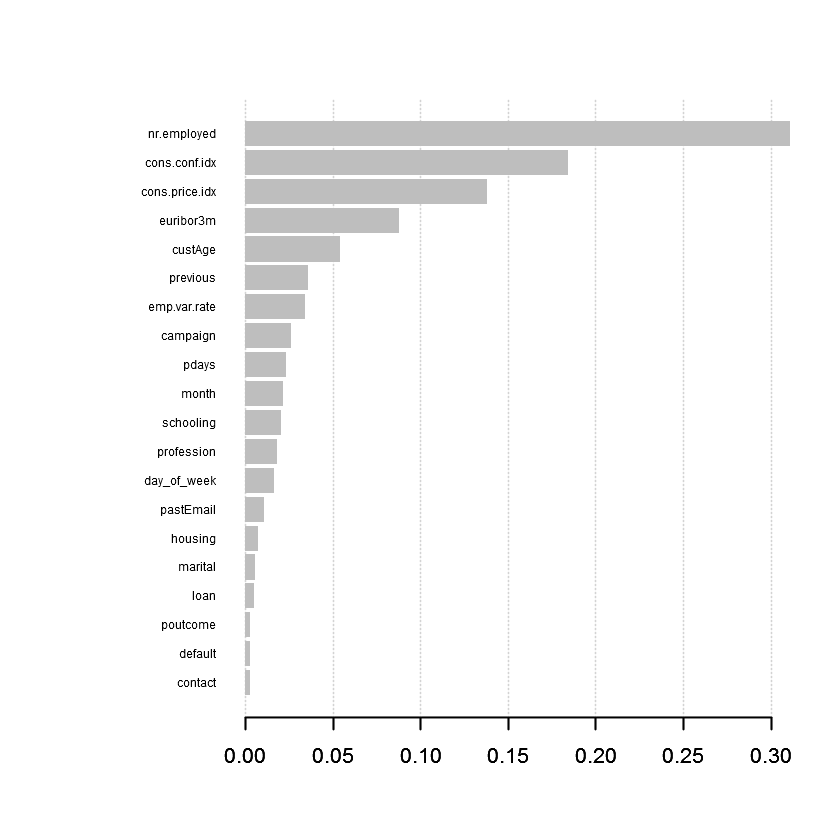

In [65]:
xgb.plot.importance (importance_matrix = mat[1:20]) 

Further models were run by taking a subset of features from the Feature Importance plot. But, there was no sign of improved results. The XGboost model was decided to be the final model. 

In [66]:
head(submission,10)

Actual,output,Predicted
no,0.9474081,no
no,0.9330713,no
no,0.9780301,no
no,0.8758960,no
no,0.9729705,no
no,0.9580494,no
no,0.9589851,no
no,0.9699380,no
no,0.9363085,no
no,0.9537542,no


## Writing test predictions to file

In [67]:
cat("saving the submission file\n")
write_csv(submission, "......./predictions.csv")

saving the submission file
